<a href="https://colab.research.google.com/github/genarioazevedoufape/projeto_bd_apache_spark/blob/main/10k%2C100k%2C1m%5B1%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🚀 Iniciando configuração para Google Colab...
✅ Executando no Google Colab
📦 Instalando Java...
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
📦 Instalando dependências...
✅ Dependências carregadas com sucesso!
🚀 Spark inicializado - Versão: 3.5.1
💾 Memória disponível: 10.2 GB

🔬 INICIANDO ANÁLISE COMPLETA DE ESCALABILIDADE
🎯 Objetivo: Testar 6 combinações em 3 tamanhos = 18 experimentos
📊 Tamanhos: 10K, 100K, 1M registros
📊 Estratégias: Standard, Sorted Neighborhood, Hash Window
📊 Métricas: WRatio, Jaccard
⚠️ Tempo estimado: 60-90 minutos

🚀 INICIANDO EXECUÇÃO DE TODOS OS EXPERIMENTOS...

🔬 EXECUTANDO EXPERIMENTOS COMPLETOS
📊 Tamanhos: [10000, 100000, 1000000]
📊 Estratégias: ['standard', 'sorted_neighborhood', 'hash_window']
📊 Métricas: ['wratio', 'jaccard']
📊 Total experimentos: 3 × 3 × 2 = 18

📊 PROCESSANDO DATASET DE 10,000 REGISTROS
🔄 Gerand

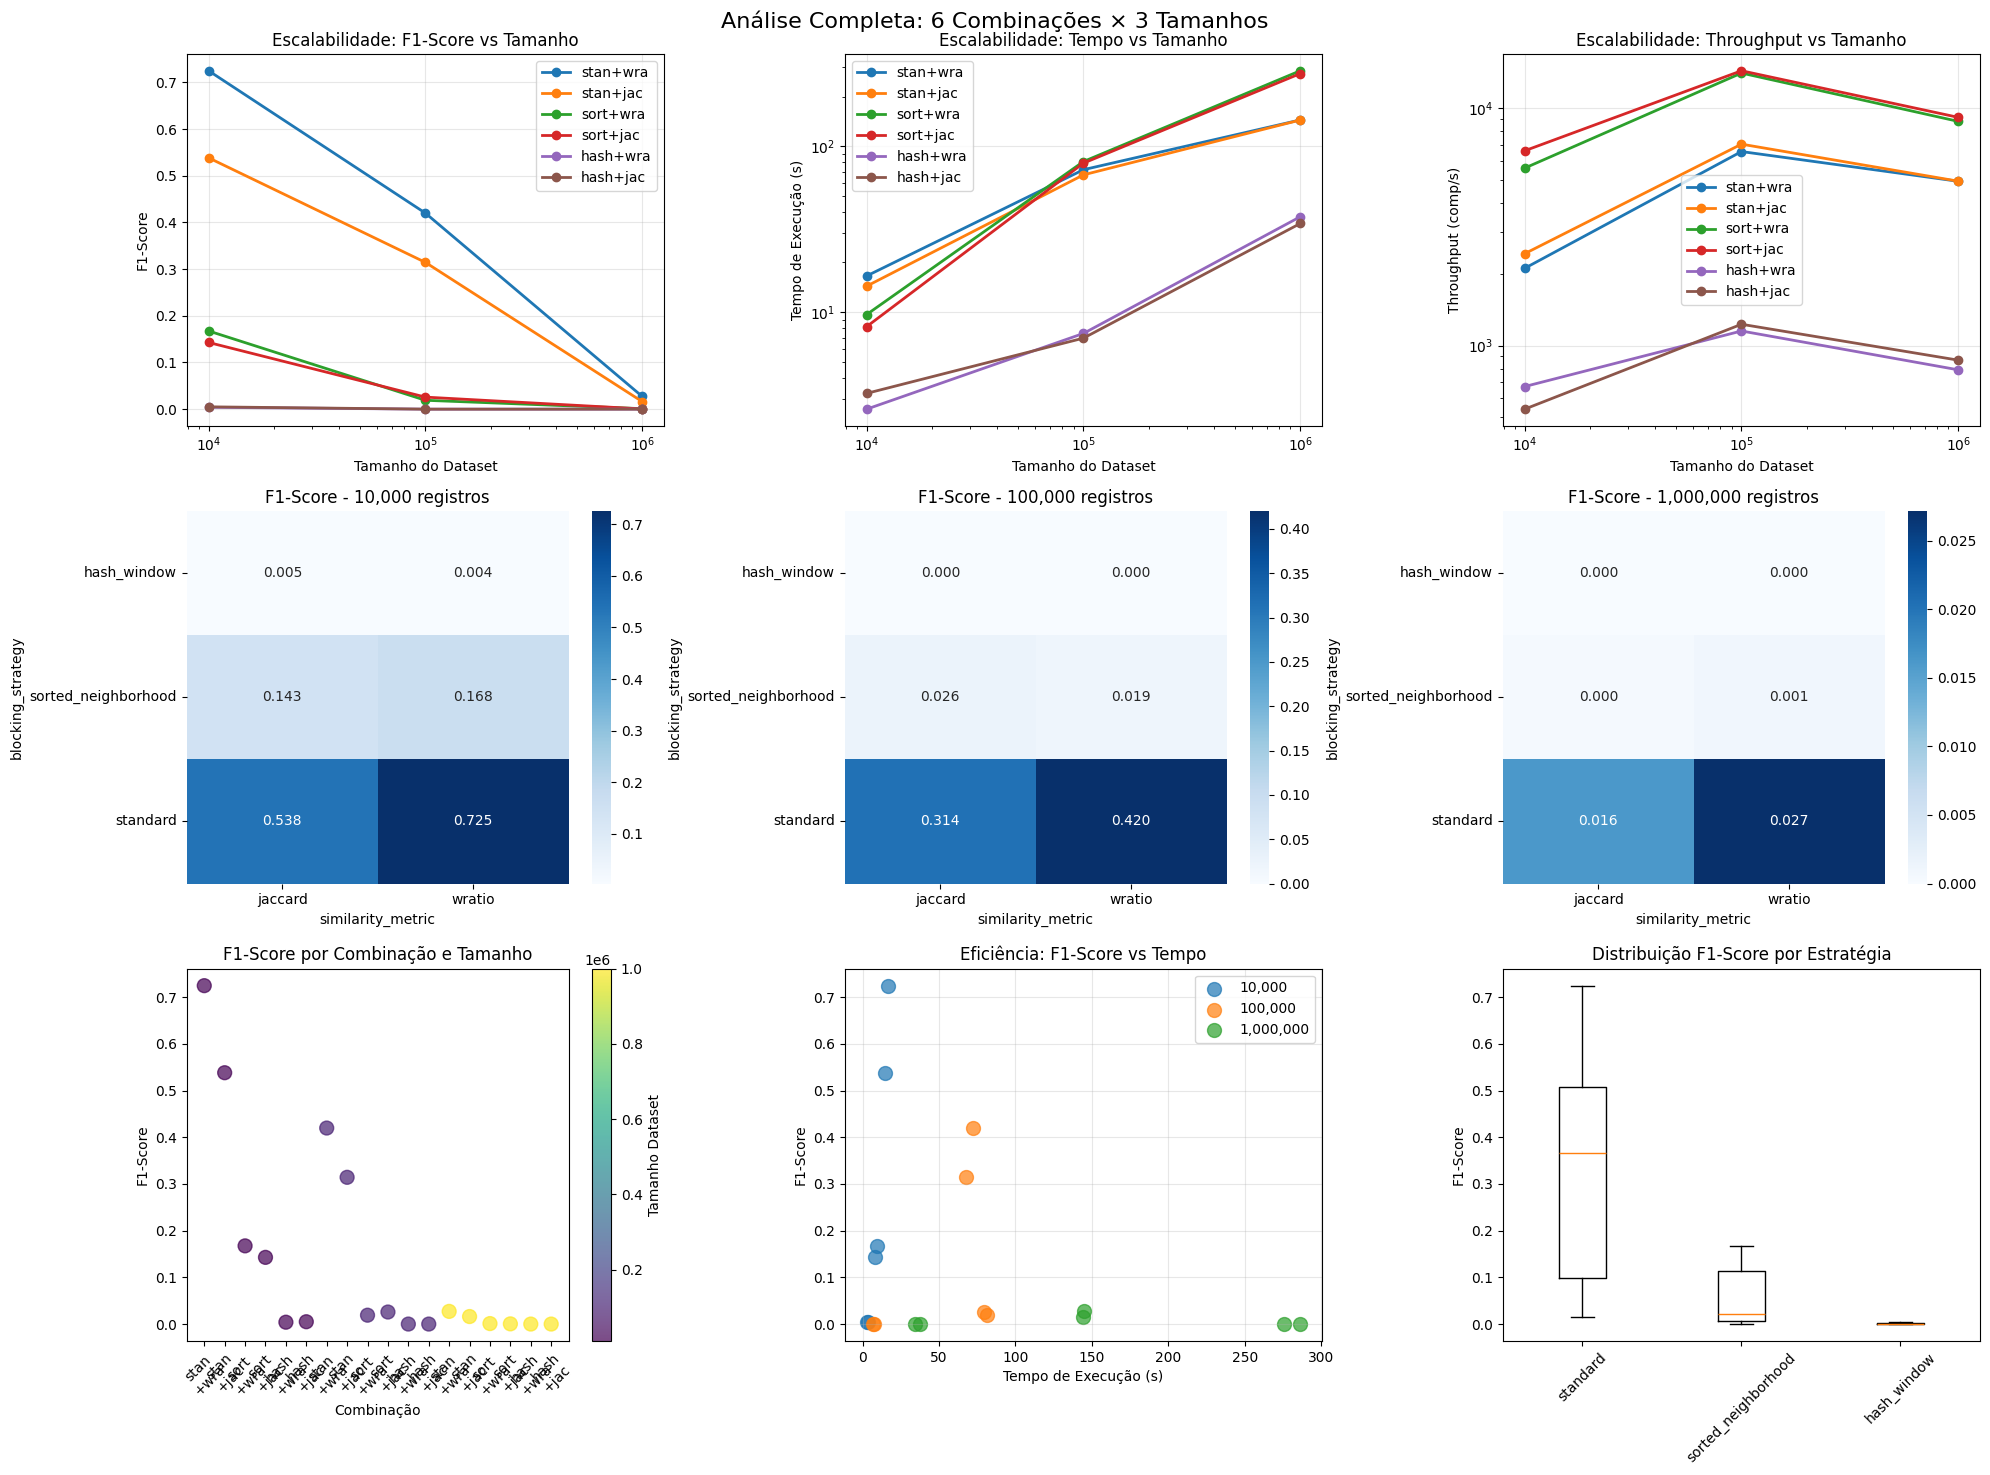


📋 RELATÓRIO COMPLETO - ANÁLISE DE ESCALABILIDADE

📊 RESUMO GERAL:
• Total de experimentos: 18
• Tamanhos testados: [np.int64(10000), np.int64(100000), np.int64(1000000)]
• Estratégias: ['standard', 'sorted_neighborhood', 'hash_window']
• Métricas: ['wratio', 'jaccard']

📈 ESTATÍSTICAS GERAIS:
• F1-Score médio: 0.134 ± 0.220
• Tempo médio: 71.75s ± 88.43s
• Throughput médio: 5104 ± 4396 comp/s

📏 ANÁLISE POR TAMANHO:

10,000 registros:
  • F1-Score médio: 0.264
  • Tempo médio: 9.08s
  • Melhor combinação: standard + wratio (F1: 0.725)

100,000 registros:
  • F1-Score médio: 0.130
  • Tempo médio: 52.40s
  • Melhor combinação: standard + wratio (F1: 0.420)

1,000,000 registros:
  • F1-Score médio: 0.007
  • Tempo médio: 153.77s
  • Melhor combinação: standard + wratio (F1: 0.027)

🏆 RANKINGS GLOBAIS:

🥇 TOP 5 F1-SCORE:
1. standard + wratio | 10,000 | F1: 0.725
2. standard + jaccard | 10,000 | F1: 0.538
3. standard + wratio | 100,000 | F1: 0.420
4. standard + jaccard | 100,000 | F1: 0.3

In [ ]:
# ===================================================================
# PIPELINE DE DEDUPLICAÇÃO DISTRIBUÍDA - VERSÃO COMPLETA
# 6 Combinações × 3 Tamanhos = 18 Experimentos Totais
# ===================================================================

print("🚀 Iniciando configuração para Google Colab...")

# Verificar se estamos no Colab e instalar dependências
try:
    import google.colab
    IN_COLAB = True
    print("✅ Executando no Google Colab")

    # Instalar Java (necessário para Spark)
    print("📦 Instalando Java...")
    import os
    !apt-get update -qq
    !apt-get install openjdk-8-jdk-headless -qq > /dev/null
    os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

    # Instalar dependências
    print("📦 Instalando dependências...")
    !pip install pyspark==3.5.1 rapidfuzz faker matplotlib seaborn -q

except ImportError:
    IN_COLAB = False
    print("⚠️ Não está no Colab")

# Imports principais
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window
import pandas as pd
from rapidfuzz import fuzz
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import combinations
import random
from faker import Faker
import warnings
import gc
import psutil
warnings.filterwarnings('ignore')

print("✅ Dependências carregadas com sucesso!")

# ===================================================================
# CONFIGURAÇÃO DO SPARK OTIMIZADA PARA MÚLTIPLOS TAMANHOS
# ===================================================================

def inicializar_spark():
    """Inicializa Spark otimizado para diferentes tamanhos"""

    spark = SparkSession.builder \
        .appName("Deduplicacao-6Combinacoes-3Tamanhos") \
        .config("spark.sql.adaptive.enabled", "true") \
        .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
        .config("spark.sql.adaptive.skewJoin.enabled", "true") \
        .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
        .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
        .config("spark.driver.memory", "4g") \
        .config("spark.driver.maxResultSize", "2g") \
        .config("spark.sql.shuffle.partitions", "200") \
        .config("spark.default.parallelism", "8") \
        .getOrCreate()

    spark.sparkContext.setLogLevel("WARN")
    print(f"🚀 Spark inicializado - Versão: {spark.version}")

    memoria_disponivel = psutil.virtual_memory().available / (1024**3)
    print(f"💾 Memória disponível: {memoria_disponivel:.1f} GB")

    return spark

spark = inicializar_spark()

# ===================================================================
# GERAÇÃO DE DADOS SINTÉTICOS ESCALÁVEL
# ===================================================================

def introduzir_erro(texto):
    """Introduz erros tipográficos realistas"""
    if len(texto) < 2:
        return texto

    erro_tipo = random.choice(['substituicao', 'remocao', 'insercao'])
    texto_lista = list(texto)

    if erro_tipo == 'substituicao' and len(texto_lista) > 0:
        pos = random.randint(0, len(texto_lista) - 1)
        texto_lista[pos] = random.choice('abcdefghijklmnopqrstuvwxyz')
    elif erro_tipo == 'remocao' and len(texto_lista) > 1:
        pos = random.randint(0, len(texto_lista) - 1)
        texto_lista.pop(pos)
    elif erro_tipo == 'insercao':
        pos = random.randint(0, len(texto_lista))
        texto_lista.insert(pos, random.choice('abcdefghijklmnopqrstuvwxyz'))

    return ''.join(texto_lista)

def gerar_dados_escalavel(num_registros, percentual_duplicatas=0.2, seed=42):
    """Gera dados sintéticos escalável para diferentes tamanhos"""
    fake = Faker('pt_BR')
    Faker.seed(seed)
    random.seed(seed)

    print(f"📝 Gerando {num_registros:,} registros com {percentual_duplicatas*100}% de duplicatas...")
    start_time = time.time()

    # Definir tamanhos dos pools baseado no tamanho do dataset
    if num_registros <= 10000:
        nome_pool_size = 2000
        sobrenome_pool_size = 1500
        cidade_pool_size = 300
        progress_step = 5000
    elif num_registros <= 100000:
        nome_pool_size = 10000
        sobrenome_pool_size = 8000
        cidade_pool_size = 1000
        progress_step = 20000
    else:  # 1M+
        nome_pool_size = 30000
        sobrenome_pool_size = 25000
        cidade_pool_size = 3000
        progress_step = 100000

    print(f"   🔄 Criando pools: {nome_pool_size} nomes, {sobrenome_pool_size} sobrenomes, {cidade_pool_size} cidades...")

    # Gerar pools eficientemente
    nomes = [fake.first_name() for _ in range(nome_pool_size)]
    sobrenomes = [fake.last_name() for _ in range(sobrenome_pool_size)]
    cidades = [fake.city() for _ in range(cidade_pool_size)]

    # Gerar registros únicos
    registros = []
    print("   🔄 Gerando registros únicos...")

    for i in range(num_registros):
        registro = {
            'id': f'rec_{i}',
            'nome': random.choice(nomes),
            'sobrenome': random.choice(sobrenomes),
            'cidade': random.choice(cidades)
        }
        registros.append(registro)

        if (i + 1) % progress_step == 0:
            print(f"      {i+1:,} registros gerados...")

    # Criar duplicatas
    ground_truth = []
    num_duplicatas = int(num_registros * percentual_duplicatas)

    print(f"   🔄 Criando {num_duplicatas:,} duplicatas...")

    for i in range(num_duplicatas):
        original_idx = random.randint(0, num_registros - 1)
        original = registros[original_idx].copy()

        duplicata = original.copy()
        duplicata['id'] = f'dup_{i}'

        # Introduzir erros
        if random.random() < 0.4:
            duplicata['nome'] = introduzir_erro(duplicata['nome'])
        if random.random() < 0.3:
            duplicata['sobrenome'] = introduzir_erro(duplicata['sobrenome'])
        if random.random() < 0.15:
            duplicata['cidade'] = introduzir_erro(duplicata['cidade'])

        registros.append(duplicata)
        ground_truth.append((original['id'], duplicata['id']))

        if (i + 1) % (progress_step // 4) == 0:
            print(f"      {i+1:,} duplicatas criadas...")

    print("   🔀 Embaralhando registros...")
    random.shuffle(registros)

    generation_time = time.time() - start_time
    print(f"✅ Dataset gerado em {generation_time:.2f}s: {len(registros):,} registros, {len(ground_truth):,} pares duplicados")

    return registros, ground_truth

# ===================================================================
# PRÉ-PROCESSAMENTO ADAPTATIVO
# ===================================================================

def preprocessar_dados_adaptativo(df, dataset_size):
    """Pré-processamento adaptativo baseado no tamanho"""
    print("🔄 Pré-processamento adaptativo...")

    df.cache()

    df_processed = df.select(
        col("id"),
        lower(regexp_replace(col("nome"), "[^a-zA-Z0-9\\s]", "")).alias("nome_norm"),
        lower(regexp_replace(col("sobrenome"), "[^a-zA-Z0-9\\s]", "")).alias("sobrenome_norm"),
        lower(regexp_replace(col("cidade"), "[^a-zA-Z0-9\\s]", "")).alias("cidade_norm"),
        col("nome").alias("nome_original"),
        col("sobrenome").alias("sobrenome_original"),
        col("cidade").alias("cidade_original")
    ).filter(
        (length(col("nome_norm")) > 0) &
        (length(col("sobrenome_norm")) > 0) &
        (length(col("cidade_norm")) > 0)
    )

    # Particionamento adaptativo
    if dataset_size <= 10000:
        num_partitions = 10
    elif dataset_size <= 100000:
        num_partitions = 50
    else:
        num_partitions = 200

    df_processed = df_processed.repartition(num_partitions)
    df_processed.cache()

    print(f"✅ Pré-processamento concluído ({num_partitions} partições)")
    return df_processed

# ===================================================================
# ESTRATÉGIAS DE BLOCKING ADAPTATIVAS
# ===================================================================

def standard_blocking_adaptativo(df, dataset_size):
    """Standard Blocking com filtros adaptativos"""
    print("🔍 Standard Blocking adaptativo...")

    df_blocked = df.withColumn(
        "block_key",
        concat(
            substring(col("nome_norm"), 1, 3),
            lit("_"),
            substring(col("cidade_norm"), 1, 2)
        )
    ).filter(length(col("block_key")) >= 5)

    # Filtro adaptativo para blocos grandes
    if dataset_size <= 10000:
        max_block_size = 200
    elif dataset_size <= 100000:
        max_block_size = 500
    else:
        max_block_size = 1000

    block_stats = df_blocked.groupBy("block_key").count()
    large_blocks = block_stats.filter(col("count") > max_block_size).collect()
    if large_blocks:
        print(f"   Filtrando {len(large_blocks)} blocos > {max_block_size}")
        large_block_keys = [row['block_key'] for row in large_blocks]
        df_blocked = df_blocked.filter(~col("block_key").isin(large_block_keys))

    return df_blocked

def sorted_neighborhood_adaptativo(df, dataset_size):
    """Sorted Neighborhood com janela adaptativa"""
    # Janela adaptativa
    if dataset_size <= 10000:
        window_size = 10
    elif dataset_size <= 100000:
        window_size = 20
    else:
        window_size = 50

    print(f"🔍 Sorted Neighborhood (window={window_size})...")

    window_spec = Window.orderBy(col("nome_norm"))
    df_sorted = df.withColumn("row_num", row_number().over(window_spec))

    df_blocked = df_sorted.withColumn(
        "block_key",
        concat(lit("win_"), (col("row_num") / window_size).cast("int"))
    ).drop("row_num")

    return df_blocked

def hash_windowed_adaptativo(df, dataset_size):
    """Hash Windowed com tamanho adaptativo"""
    # Tamanho de janela adaptativo
    if dataset_size <= 10000:
        window_size = 50
    elif dataset_size <= 100000:
        window_size = 200
    else:
        window_size = 500

    print(f"🔍 Hash Windowed (window={window_size})...")

    df_blocked = df.withColumn(
        "block_key",
        concat(lit("hash_"), (abs(hash(col("nome_norm"))) % window_size).cast("string"))
    )

    return df_blocked

# ===================================================================
# COMPARAÇÃO ADAPTATIVA
# ===================================================================

def comparar_pares_adaptativo(registros_bloco, similarity_metric='wratio', threshold=85.0, dataset_size=10000):
    """Comparação com limites adaptativos"""
    if len(registros_bloco) < 2:
        return []

    # Limite adaptativo
    if dataset_size <= 10000:
        max_records = 30
    elif dataset_size <= 100000:
        max_records = 20
    else:
        max_records = 15

    if len(registros_bloco) > max_records:
        registros_bloco = random.sample(registros_bloco, max_records)

    resultados = []

    for i in range(len(registros_bloco)):
        for j in range(i + 1, len(registros_bloco)):
            row1 = registros_bloco[i]
            row2 = registros_bloco[j]

            try:
                if similarity_metric == 'wratio':
                    sim_nome = fuzz.WRatio(row1['nome_norm'], row2['nome_norm'])
                    sim_sobrenome = fuzz.WRatio(row1['sobrenome_norm'], row2['sobrenome_norm'])
                    similarity_score = (sim_nome * 0.4 + sim_sobrenome * 0.6)

                elif similarity_metric == 'jaccard':
                    text1 = f"{row1['nome_norm']} {row1['sobrenome_norm']}"
                    text2 = f"{row2['nome_norm']} {row2['sobrenome_norm']}"

                    set1 = set(text1.split())
                    set2 = set(text2.split())
                    intersection = len(set1.intersection(set2))
                    union = len(set1.union(set2))
                    similarity_score = (intersection / union * 100) if union > 0 else 0

                else:
                    similarity_score = 0

                resultados.append({
                    'id1': row1['id'],
                    'id2': row2['id'],
                    'similarity_score': float(similarity_score),
                    'is_duplicate': 'yes' if similarity_score >= threshold else 'no'
                })

            except Exception:
                continue

    return resultados

def processar_comparacoes_adaptativo(df_blocked, similarity_metric='wratio', threshold=85.0, dataset_size=10000):
    """Processamento adaptativo baseado no tamanho"""
    print(f"⚡ Comparações {similarity_metric} (dataset: {dataset_size:,})...")

    block_stats = df_blocked.groupBy("block_key").count()
    total_blocks = block_stats.count()

    if total_blocks == 0:
        schema = StructType([
            StructField("id1", StringType(), True),
            StructField("id2", StringType(), True),
            StructField("similarity_score", DoubleType(), True),
            StructField("is_duplicate", StringType(), True)
        ])
        return spark.createDataFrame([], schema)

    # Filtros adaptativos
    if dataset_size <= 10000:
        min_block_size, max_block_size = 2, 100
        batch_size = 500
    elif dataset_size <= 100000:
        min_block_size, max_block_size = 2, 200
        batch_size = 1000
    else:
        min_block_size, max_block_size = 2, 300
        batch_size = 2000

    valid_blocks = block_stats.filter((col("count") >= min_block_size) & (col("count") <= max_block_size))
    valid_block_keys = [row['block_key'] for row in valid_blocks.collect()]

    print(f"   📊 Blocos válidos: {len(valid_block_keys):,}")

    if not valid_block_keys:
        schema = StructType([
            StructField("id1", StringType(), True),
            StructField("id2", StringType(), True),
            StructField("similarity_score", DoubleType(), True),
            StructField("is_duplicate", StringType(), True)
        ])
        return spark.createDataFrame([], schema)

    df_filtered = df_blocked.filter(col("block_key").isin(valid_block_keys))

    # Processar em lotes
    todos_resultados = []
    num_batches = (len(valid_block_keys) + batch_size - 1) // batch_size

    for i in range(0, len(valid_block_keys), batch_size):
        batch_keys = valid_block_keys[i:i + batch_size]
        batch_num = i // batch_size + 1

        print(f"   🔄 Lote {batch_num}/{num_batches}")

        df_batch = df_filtered.filter(col("block_key").isin(batch_keys))

        try:
            blocos_batch = df_batch.groupBy("block_key").agg(collect_list(
                struct(
                    col("id"),
                    col("nome_norm"),
                    col("sobrenome_norm"),
                    col("cidade_norm")
                )
            ).alias("registros")).collect()

            for bloco in blocos_batch:
                registros = [row.asDict() for row in bloco['registros']]

                if len(registros) >= 2:
                    resultados_bloco = comparar_pares_adaptativo(
                        registros, similarity_metric, threshold, dataset_size
                    )
                    todos_resultados.extend(resultados_bloco)

            del blocos_batch
            gc.collect()

        except Exception as e:
            print(f"      ❌ Erro no lote {batch_num}: {str(e)}")
            continue

    print(f"   ✅ Total comparações: {len(todos_resultados):,}")

    # Converter para DataFrame
    if todos_resultados:
        # Para datasets grandes, processar em chunks
        if len(todos_resultados) > 100000:
            chunk_size = 50000
            dfs = []
            for i in range(0, len(todos_resultados), chunk_size):
                chunk = todos_resultados[i:i + chunk_size]
                try:
                    df_chunk = spark.createDataFrame(chunk)
                    dfs.append(df_chunk)
                except:
                    continue

            if dfs:
                df_final = dfs[0]
                for df_chunk in dfs[1:]:
                    df_final = df_final.union(df_chunk)
                return df_final
        else:
            return spark.createDataFrame(todos_resultados)

    schema = StructType([
        StructField("id1", StringType(), True),
        StructField("id2", StringType(), True),
        StructField("similarity_score", DoubleType(), True),
        StructField("is_duplicate", StringType(), True)
    ])
    return spark.createDataFrame([], schema)

# ===================================================================
# AVALIAÇÃO ADAPTATIVA
# ===================================================================

def avaliar_qualidade_adaptativo(df_comparisons, ground_truth_pairs, dataset_size):
    """Avaliação adaptativa baseada no tamanho"""
    print("📊 Avaliando qualidade...")

    gt_set = set()
    for id1, id2 in ground_truth_pairs:
        pair = tuple(sorted([id1, id2]))
        gt_set.add(pair)

    print(f"   📊 Ground truth: {len(gt_set):,} pares")

    try:
        duplicates_count = df_comparisons.filter(col("is_duplicate") == "yes").count()
        print(f"   📊 Duplicatas preditas: {duplicates_count:,}")

        # Amostragem adaptativa
        if dataset_size >= 1000000 and duplicates_count > 50000:
            sample_fraction = 50000.0 / duplicates_count
            predicted_duplicates = df_comparisons.filter(col("is_duplicate") == "yes").sample(sample_fraction, seed=42).collect()
            # Ajustar ground truth proporcionalmente
            if len(gt_set) > 10000:
                gt_sample_size = int(len(gt_set) * sample_fraction)
                gt_set = set(random.sample(list(gt_set), gt_sample_size))
        elif dataset_size >= 100000 and duplicates_count > 20000:
            sample_fraction = 0.5
            predicted_duplicates = df_comparisons.filter(col("is_duplicate") == "yes").sample(sample_fraction, seed=42).collect()
        else:
            predicted_duplicates = df_comparisons.filter(col("is_duplicate") == "yes").collect()

        predicted_set = set()
        for row in predicted_duplicates:
            pair = tuple(sorted([row['id1'], row['id2']]))
            predicted_set.add(pair)

        # Calcular métricas
        tp = len(gt_set.intersection(predicted_set))
        fp = len(predicted_set - gt_set)
        fn = len(gt_set - predicted_set)

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        metricas = {
            'precision': precision,
            'recall': recall,
            'f1_score': f1_score,
            'true_positives': tp,
            'false_positives': fp,
            'false_negatives': fn,
            'total_predicted': len(predicted_set),
            'total_ground_truth': len(gt_set)
        }

        print(f"✅ P: {precision:.3f} | R: {recall:.3f} | F1: {f1_score:.3f}")
        return metricas

    except Exception as e:
        print(f"   ❌ Erro: {str(e)}")
        return {
            'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0,
            'true_positives': 0, 'false_positives': 0, 'false_negatives': len(gt_set),
            'total_predicted': 0, 'total_ground_truth': len(gt_set)
        }

# ===================================================================
# PIPELINE COMPLETO PARA MÚLTIPLOS TAMANHOS
# ===================================================================

class PipelineMultiTamanho:
    """Pipeline que roda todas as combinações em múltiplos tamanhos"""

    def __init__(self, spark_session):
        self.spark = spark_session
        self.strategies = {
            'standard': standard_blocking_adaptativo,
            'sorted_neighborhood': sorted_neighborhood_adaptativo,
            'hash_window': hash_windowed_adaptativo
        }
        self.metrics = ['wratio', 'jaccard']

    def executar_pipeline_completo(self, df, ground_truth, dataset_size, blocking_strategy, similarity_metric):
        """Executa pipeline completo para um tamanho específico"""
        print(f"\n🚀 {blocking_strategy.upper()} + {similarity_metric.upper()} | Dataset: {dataset_size:,}")

        start_time = time.time()

        try:
            df.cache()

            # Pré-processamento
            df_preprocessed = preprocessar_dados_adaptativo(df, dataset_size)

            # Blocking
            df_blocked = self.strategies[blocking_strategy](df_preprocessed, dataset_size)

            # Comparação
            df_comparisons = processar_comparacoes_adaptativo(df_blocked, similarity_metric, 85.0, dataset_size)

            # Avaliação
            metricas = avaliar_qualidade_adaptativo(df_comparisons, ground_truth, dataset_size)

            # Métricas finais
            execution_time = time.time() - start_time
            total_comparisons = df_comparisons.count() if df_comparisons else 0
            throughput = total_comparisons / execution_time if execution_time > 0 else 0

            resultado = {
                'dataset_size': dataset_size,
                'blocking_strategy': blocking_strategy,
                'similarity_metric': similarity_metric,
                'execution_time': execution_time,
                'total_comparisons': total_comparisons,
                'throughput': throughput,
                **metricas
            }

            print(f"⏱️ {execution_time:.2f}s | F1: {metricas['f1_score']:.3f} | Throughput: {throughput:.0f}")

            # Limpeza
            try:
                df_preprocessed.unpersist()
                df_blocked.unpersist()
                df_comparisons.unpersist()
            except:
                pass

            return resultado

        except Exception as e:
            print(f"❌ Erro: {str(e)}")
            return None

    def executar_todos_experimentos(self, dataset_sizes):
        """Executa todos os experimentos: 6 combinações × N tamanhos"""
        print(f"\n🔬 EXECUTANDO EXPERIMENTOS COMPLETOS")
        print("="*60)
        print(f"📊 Tamanhos: {dataset_sizes}")
        print(f"📊 Estratégias: {list(self.strategies.keys())}")
        print(f"📊 Métricas: {self.metrics}")
        print(f"📊 Total experimentos: {len(dataset_sizes)} × 3 × 2 = {len(dataset_sizes) * 6}")

        todos_resultados = []
        experimento_atual = 0
        total_experimentos = len(dataset_sizes) * len(self.strategies) * len(self.metrics)

        for size in dataset_sizes:
            print(f"\n{'='*80}")
            print(f"📊 PROCESSANDO DATASET DE {size:,} REGISTROS")
            print('='*80)

            # Gerar dataset
            print(f"🔄 Gerando dataset...")
            start_gen = time.time()

            dados_lista, ground_truth = gerar_dados_escalavel(
                num_registros=size,
                percentual_duplicatas=0.2,
                seed=42
            )

            # Converter para Spark
            df_spark = spark.createDataFrame(dados_lista)

            # Particionamento otimizado
            if size <= 10000:
                num_partitions = 10
            elif size <= 100000:
                num_partitions = 50
            else:
                num_partitions = 200

            df_spark = df_spark.repartition(num_partitions).cache()
            df_spark.count()  # Materializar

            gen_time = time.time() - start_gen
            print(f"✅ Dataset gerado em {gen_time:.2f}s")

            # Limpeza de memória
            del dados_lista
            gc.collect()

            # Executar todas as combinações para este tamanho
            for strategy in self.strategies.keys():
                for metric in self.metrics:
                    experimento_atual += 1
                    print(f"\n{'='*60}")
                    print(f"🧪 EXPERIMENTO {experimento_atual}/{total_experimentos}")
                    print(f"📊 {size:,} registros | {strategy} + {metric}")
                    print('='*60)

                    resultado = self.executar_pipeline_completo(
                        df_spark, ground_truth, size, strategy, metric
                    )

                    if resultado:
                        todos_resultados.append(resultado)
                        print(f"✅ Sucesso!")
                    else:
                        print(f"❌ Falhou!")

                    # Limpeza entre experimentos
                    gc.collect()

            # Limpeza entre datasets
            df_spark.unpersist()
            gc.collect()

        return todos_resultados

# ===================================================================
# VISUALIZAÇÃO COMPLETA
# ===================================================================

def plotar_resultados_completos(resultados):
    """Visualizações para múltiplos tamanhos e combinações"""
    if not resultados:
        print("⚠️ Nenhum resultado")
        return

    df_results = pd.DataFrame([r for r in resultados if r is not None])

    if len(df_results) == 0:
        return

    # Criar figura grande
    fig, axes = plt.subplots(3, 3, figsize=(20, 15))
    fig.suptitle('Análise Completa: 6 Combinações × 3 Tamanhos', fontsize=16)

    try:
        # 1. Escalabilidade F1-Score
        ax1 = axes[0,0]
        for strategy in df_results['blocking_strategy'].unique():
            for metric in df_results['similarity_metric'].unique():
                data = df_results[(df_results['blocking_strategy'] == strategy) &
                                (df_results['similarity_metric'] == metric)]
                if len(data) > 1:
                    ax1.plot(data['dataset_size'], data['f1_score'],
                            'o-', label=f'{strategy[:4]}+{metric[:3]}', linewidth=2)

        ax1.set_xlabel('Tamanho do Dataset')
        ax1.set_ylabel('F1-Score')
        ax1.set_title('Escalabilidade: F1-Score vs Tamanho')
        ax1.set_xscale('log')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # 2. Escalabilidade Tempo
        ax2 = axes[0,1]
        for strategy in df_results['blocking_strategy'].unique():
            for metric in df_results['similarity_metric'].unique():
                data = df_results[(df_results['blocking_strategy'] == strategy) &
                                (df_results['similarity_metric'] == metric)]
                if len(data) > 1:
                    ax2.plot(data['dataset_size'], data['execution_time'],
                            'o-', label=f'{strategy[:4]}+{metric[:3]}', linewidth=2)

        ax2.set_xlabel('Tamanho do Dataset')
        ax2.set_ylabel('Tempo de Execução (s)')
        ax2.set_title('Escalabilidade: Tempo vs Tamanho')
        ax2.set_xscale('log')
        ax2.set_yscale('log')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        # 3. Escalabilidade Throughput
        ax3 = axes[0,2]
        for strategy in df_results['blocking_strategy'].unique():
            for metric in df_results['similarity_metric'].unique():
                data = df_results[(df_results['blocking_strategy'] == strategy) &
                                (df_results['similarity_metric'] == metric)]
                if len(data) > 1:
                    ax3.plot(data['dataset_size'], data['throughput'],
                            'o-', label=f'{strategy[:4]}+{metric[:3]}', linewidth=2)

        ax3.set_xlabel('Tamanho do Dataset')
        ax3.set_ylabel('Throughput (comp/s)')
        ax3.set_title('Escalabilidade: Throughput vs Tamanho')
        ax3.set_xscale('log')
        ax3.set_yscale('log')
        ax3.legend()
        ax3.grid(True, alpha=0.3)

        # 4-6. Heatmaps por tamanho
        for i, size in enumerate(sorted(df_results['dataset_size'].unique())):
            ax = axes[1, i]
            size_data = df_results[df_results['dataset_size'] == size]

            if len(size_data) > 0:
                pivot = size_data.pivot_table(values='f1_score',
                                            index='blocking_strategy',
                                            columns='similarity_metric',
                                            aggfunc='mean')

                sns.heatmap(pivot, annot=True, fmt='.3f', cmap='Blues', ax=ax)
                ax.set_title(f'F1-Score - {size:,} registros')

        # 7. Comparação geral F1-Score
        ax7 = axes[2,0]
        combinations = []
        f1_scores = []
        colors = []

        for _, row in df_results.iterrows():
            combo = f"{row['blocking_strategy'][:4]}\n+{row['similarity_metric'][:3]}"
            combinations.append(combo)
            f1_scores.append(row['f1_score'])
            colors.append(row['dataset_size'])

        scatter = ax7.scatter(range(len(combinations)), f1_scores, c=colors,
                             cmap='viridis', s=100, alpha=0.7)
        ax7.set_xlabel('Combinação')
        ax7.set_ylabel('F1-Score')
        ax7.set_title('F1-Score por Combinação e Tamanho')
        ax7.set_xticks(range(len(combinations)))
        ax7.set_xticklabels(combinations, rotation=45)
        plt.colorbar(scatter, ax=ax7, label='Tamanho Dataset')

        # 8. Eficiência: F1 vs Tempo
        ax8 = axes[2,1]
        for size in df_results['dataset_size'].unique():
            size_data = df_results[df_results['dataset_size'] == size]
            ax8.scatter(size_data['execution_time'], size_data['f1_score'],
                       label=f'{size:,}', s=100, alpha=0.7)

        ax8.set_xlabel('Tempo de Execução (s)')
        ax8.set_ylabel('F1-Score')
        ax8.set_title('Eficiência: F1-Score vs Tempo')
        ax8.legend()
        ax8.grid(True, alpha=0.3)

        # 9. Box plot por estratégia
        ax9 = axes[2,2]
        strategies = []
        f1_data = []

        for strategy in df_results['blocking_strategy'].unique():
            strategy_data = df_results[df_results['blocking_strategy'] == strategy]
            strategies.append(strategy)
            f1_data.append(strategy_data['f1_score'].tolist())

        ax9.boxplot(f1_data, labels=strategies)
        ax9.set_ylabel('F1-Score')
        ax9.set_title('Distribuição F1-Score por Estratégia')
        ax9.tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"⚠️ Erro na plotagem: {str(e)}")
        print("\n📊 RESULTADOS EM TABELA:")
        display_cols = ['dataset_size', 'blocking_strategy', 'similarity_metric', 'f1_score', 'execution_time']
        print(df_results[display_cols].round(3))

def gerar_relatorio_completo(resultados):
    """Relatório completo com análise de escalabilidade"""
    print("\n" + "="*80)
    print("📋 RELATÓRIO COMPLETO - ANÁLISE DE ESCALABILIDADE")
    print("="*80)

    if not resultados:
        print("⚠️ Nenhum resultado")
        return

    df_results = pd.DataFrame([r for r in resultados if r is not None])

    print(f"\n📊 RESUMO GERAL:")
    print(f"• Total de experimentos: {len(df_results)}")
    print(f"• Tamanhos testados: {sorted(df_results['dataset_size'].unique())}")
    print(f"• Estratégias: {list(df_results['blocking_strategy'].unique())}")
    print(f"• Métricas: {list(df_results['similarity_metric'].unique())}")

    print(f"\n📈 ESTATÍSTICAS GERAIS:")
    print(f"• F1-Score médio: {df_results['f1_score'].mean():.3f} ± {df_results['f1_score'].std():.3f}")
    print(f"• Tempo médio: {df_results['execution_time'].mean():.2f}s ± {df_results['execution_time'].std():.2f}s")
    print(f"• Throughput médio: {df_results['throughput'].mean():.0f} ± {df_results['throughput'].std():.0f} comp/s")

    # Análise por tamanho
    print(f"\n📏 ANÁLISE POR TAMANHO:")
    for size in sorted(df_results['dataset_size'].unique()):
        size_data = df_results[df_results['dataset_size'] == size]
        print(f"\n{size:,} registros:")
        print(f"  • F1-Score médio: {size_data['f1_score'].mean():.3f}")
        print(f"  • Tempo médio: {size_data['execution_time'].mean():.2f}s")
        print(f"  • Melhor combinação: {size_data.loc[size_data['f1_score'].idxmax()]['blocking_strategy']} + {size_data.loc[size_data['f1_score'].idxmax()]['similarity_metric']} (F1: {size_data['f1_score'].max():.3f})")

    # Rankings globais
    print(f"\n🏆 RANKINGS GLOBAIS:")

    # Top F1-Score
    top_f1 = df_results.nlargest(5, 'f1_score')
    print(f"\n🥇 TOP 5 F1-SCORE:")
    for i, (_, row) in enumerate(top_f1.iterrows(), 1):
        print(f"{i}. {row['blocking_strategy']} + {row['similarity_metric']} | {row['dataset_size']:,} | F1: {row['f1_score']:.3f}")

    # Top Velocidade
    top_speed = df_results.nsmallest(5, 'execution_time')
    print(f"\n⚡ TOP 5 VELOCIDADE:")
    for i, (_, row) in enumerate(top_speed.iterrows(), 1):
        print(f"{i}. {row['blocking_strategy']} + {row['similarity_metric']} | {row['dataset_size']:,} | {row['execution_time']:.2f}s")

    # Análise de escalabilidade
    print(f"\n📈 ANÁLISE DE ESCALABILIDADE:")
    for strategy in df_results['blocking_strategy'].unique():
        for metric in df_results['similarity_metric'].unique():
            combo_data = df_results[(df_results['blocking_strategy'] == strategy) &
                                  (df_results['similarity_metric'] == metric)].sort_values('dataset_size')

            if len(combo_data) >= 2:
                first_size = combo_data.iloc[0]['dataset_size']
                last_size = combo_data.iloc[-1]['dataset_size']
                first_time = combo_data.iloc[0]['execution_time']
                last_time = combo_data.iloc[-1]['execution_time']

                size_ratio = last_size / first_size
                time_ratio = last_time / first_time
                efficiency = size_ratio / time_ratio

                print(f"\n{strategy} + {metric}:")
                print(f"  • Tamanho: {first_size:,} → {last_size:,} ({size_ratio:.1f}x)")
                print(f"  • Tempo: {first_time:.2f}s → {last_time:.2f}s ({time_ratio:.1f}x)")
                print(f"  • Eficiência: {efficiency:.2f}")

    print(f"\n💡 RECOMENDAÇÕES FINAIS:")

    # Melhor para cada tamanho
    for size in sorted(df_results['dataset_size'].unique()):
        size_data = df_results[df_results['dataset_size'] == size]
        best = size_data.loc[size_data['f1_score'].idxmax()]
        print(f"• {size:,} registros: {best['blocking_strategy']} + {best['similarity_metric']} (F1: {best['f1_score']:.3f})")

    # Recomendação geral
    overall_best = df_results.loc[df_results['f1_score'].idxmax()]
    print(f"• Melhor geral: {overall_best['blocking_strategy']} + {overall_best['similarity_metric']} (F1: {overall_best['f1_score']:.3f})")

# ===================================================================
# EXECUÇÃO PRINCIPAL - TODOS OS EXPERIMENTOS
# ===================================================================

print("\n🔬 INICIANDO ANÁLISE COMPLETA DE ESCALABILIDADE")
print("="*60)
print("🎯 Objetivo: Testar 6 combinações em 3 tamanhos = 18 experimentos")
print("📊 Tamanhos: 10K, 100K, 1M registros")
print("📊 Estratégias: Standard, Sorted Neighborhood, Hash Window")
print("📊 Métricas: WRatio, Jaccard")
print("⚠️ Tempo estimado: 60-90 minutos")

# Configurar tamanhos de dataset
DATASET_SIZES = [10000, 100000, 1000000]  # 10K, 100K, 1M

# Instanciar pipeline
pipeline = PipelineMultiTamanho(spark)

# Executar todos os experimentos
print(f"\n🚀 INICIANDO EXECUÇÃO DE TODOS OS EXPERIMENTOS...")
start_total = time.time()

resultados_todos = pipeline.executar_todos_experimentos(DATASET_SIZES)

total_time = time.time() - start_total

print(f"\n🎯 TODOS OS EXPERIMENTOS CONCLUÍDOS!")
print(f"⏱️ Tempo total: {total_time:.2f}s ({total_time/60:.1f} minutos)")
print(f"📊 Experimentos bem-sucedidos: {len(resultados_todos)}/18")

# Análises finais
if resultados_todos:
    print("\n📊 Gerando análises completas...")

    # Visualizações
    plotar_resultados_completos(resultados_todos)

    # Relatório
    gerar_relatorio_completo(resultados_todos)

    # Salvar resultados
    try:
        df_final = pd.DataFrame(resultados_todos)
        df_final.to_csv('resultados_escalabilidade_completa.csv', index=False)
        print("💾 Resultados salvos em 'resultados_escalabilidade_completa.csv'")
    except Exception as e:
        print(f"⚠️ Erro ao salvar: {str(e)}")

    # Análise estatística final
    print(f"\n🔍 ANÁLISE ESTATÍSTICA:")
    df_final = pd.DataFrame(resultados_todos)

    # Correlações
    numerical_cols = ['dataset_size', 'f1_score', 'execution_time', 'throughput']
    correlation_matrix = df_final[numerical_cols].corr()
    print("📊 Matriz de correlação:")
    print(correlation_matrix.round(3))

else:
    print("❌ Nenhum experimento foi bem-sucedido")

print(f"\n✅ PROJETO CONCLUÍDO!")
print("🎯 Análise completa de escalabilidade finalizada!")
print("📊 6 combinações × 3 tamanhos = 18 experimentos realizados")
print("🚀 Pipeline validado para deduplicação distribuída em larga escala")

# Finalizar Spark
print("\n🔄 Finalizando Spark...")
spark.stop()
print("✅ Finalizado!")